In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove

In [16]:
def image_matting(object_image_path, background_image_path):
    # Read the object image
    object_image = cv2.imread(object_image_path)
    object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)
    object_image = remove(object_image)
    
    # Read the background image
    background_image = cv2.imread(background_image_path)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

    # Resize the background image to match the object image size
    background_image = cv2.resize(background_image, (object_image.shape[1], object_image.shape[0]))

    # Convert object image to grayscale
    gray = cv2.cvtColor(object_image, cv2.COLOR_RGB2GRAY)
    
    # Thresholding to get a binary mask
    ret, binary_mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    
    # Invert binary mask
    binary_mask = cv2.bitwise_not(binary_mask)
    
    # Convert binary mask to alpha matte
    alpha_matte = binary_mask.astype(np.float32) / 255.0
    
    # Composite object image and background image using alpha matte
    result = np.zeros_like(object_image, dtype=np.uint8)
    for i in range(3):
        result[:,:,i] = alpha_matte * object_image[:,:,i] + (1 - alpha_matte) * background_image[:,:,i]
    
    return object_image, background_image, result, binary_mask

In [ ]:
def image_matting(object_image_path, background_image_path):
    # Read the object image
    object_image = cv2.imread(object_image_path)
    object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)
    
    # Read the background image
    background_image = cv2.imread(background_image_path)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

    # Resize the background image to match the object image size
    background_image = cv2.resize(background_image, (object_image.shape[1], object_image.shape[0]))

    # Create a mask initialized as background
    mask = np.zeros(object_image.shape[:2], np.uint8)
    mask[:,:] = cv2.GC_PR_BGD  # Set all pixels to probable background

    # Define a rectangle enclosing the object
    rect = (10, 10, object_image.shape[1] - 20, object_image.shape[0] - 20)  # (x, y, width, height)

    # Apply GrabCut to refine the mask
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(object_image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Create a binary mask where probable and definite foreground pixels are set to 1
    binary_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8) * 255

    # Convert binary mask to alpha matte
    alpha_matte = binary_mask.astype(np.float32) / 255.0
    
    # Composite object image and background image using alpha matte
    result = np.zeros_like(object_image, dtype=np.uint8)
    for i in range(3):
        result[:,:,i] = alpha_matte * object_image[:,:,i] + (1 - alpha_matte) * background_image[:,:,i]
    
    return object_image, background_image, result, binary_mask

In [17]:
def plot_images(object_image, background_image, result_image, binary_mask):
    plt.figure(figsize=(20, 8))
    
    # Object image
    plt.subplot(1, 4, 1)
    plt.imshow(object_image)
    plt.title('Object Image')
    plt.axis('off')
    
    # Background image
    plt.subplot(1, 4, 2)
    plt.imshow(background_image)
    plt.title('Background Image')
    plt.axis('off')

    # Binary mask
    plt.subplot(1, 4, 4)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')
    
    # Result image
    plt.subplot(1, 4, 3)
    plt.imshow(result_image)
    plt.title('Result')
    plt.axis('off')

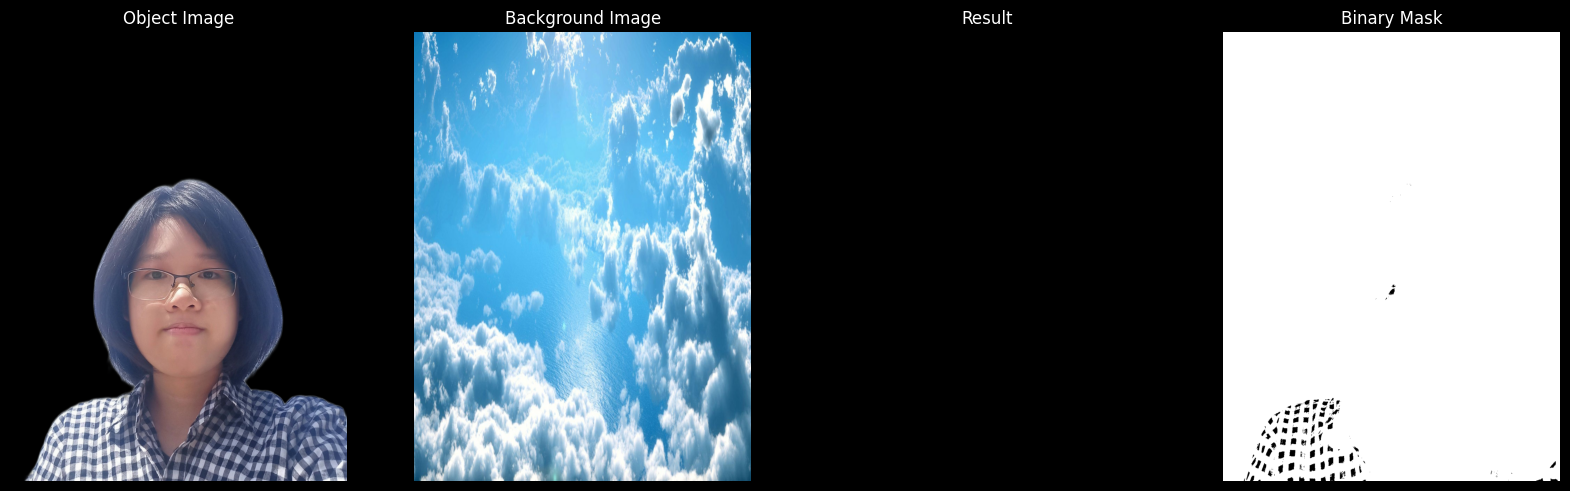

In [18]:
object_image_path = 'rika.jpg'  # Replace with your object image file path
background_image_path = 'background.jpg'  # Replace with your background image file path

object_image, background_image, result_image, binary_mask= image_matting(object_image_path, background_image_path)
plot_images(object_image, background_image, result_image, binary_mask)